#### Internshala NLP News Classification Project

video Explanation link : https://drive.google.com/file/d/17vDOiBHla5OcWOqdi7b_0FaOS3dBU2jD/view?usp=sharing

In [2]:
# Importing Neccessary Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
import unicodedata

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from wordcloud import WordCloud
from gensim.models import Word2Vec
from scipy.stats import uniform

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\danis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [10]:
# 2. Load Data
df = pd.read_excel('data_news.xlsx')
df.head()

category                                           headline  \
0  WELLNESS              143 Miles in 35 Days: Lessons Learned   
1  WELLNESS       Talking to Yourself: Crazy or Crazy Helpful?   
2  WELLNESS  Crenezumab: Trial Will Gauge Whether Alzheimer...   
3  WELLNESS                     Oh, What a Difference She Made   
4  WELLNESS                                   Green Superfoods   

                                               links  \
0  https://www.huffingtonpost.com/entry/running-l...   
1  https://www.huffingtonpost.com/entry/talking-t...   
2  https://www.huffingtonpost.com/entry/crenezuma...   
3  https://www.huffingtonpost.com/entry/meaningfu...   
4  https://www.huffingtonpost.com/entry/green-sup...   

                                   short_description  \
0  Resting is part of training. I've confirmed wh...   
1  Think of talking to yourself as a tool to coac...   
2  The clock is ticking for the United States to ...   
3  If you want to be busy, keep trying to be perf...   
4  First, the bad news: Soda bread, corned beef a...   

                             keywords  
0                     running-lessons  
1           talking-to-yourself-crazy  
2  crenezumab-alzheimers-disease-drug  
3                     meaningful-life  
4                    green-superfoods

In [11]:
print(df.describe())

        category        headline  \
count      50000           50000   
unique        10           45577   
top     WELLNESS  Sunday Roundup   
freq        5000              22   

                                                    links  \
count                                               50000   
unique                                              45745   
top     https://www.huffingtonpost.com/entry/bryce-har...   
freq                                                    8   

                                        short_description keywords  
count                                               49994    47294  
unique                                              45741    41557  
top     Along with his fists, the star Nationals outfi...     post  
freq                                                    8       85  


In [3]:
df.dropna(subset=['category', 'headline', 'short_description'], inplace=True)
df['content'] = df['headline'] + ' ' + df['short_description']

In [4]:
# 3. Preprocessing
def preprocess_text(text):
    text = text.lower()
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = text.split()
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return ' '.join(tokens)

df['cleaned_content'] = df['content'].apply(preprocess_text)

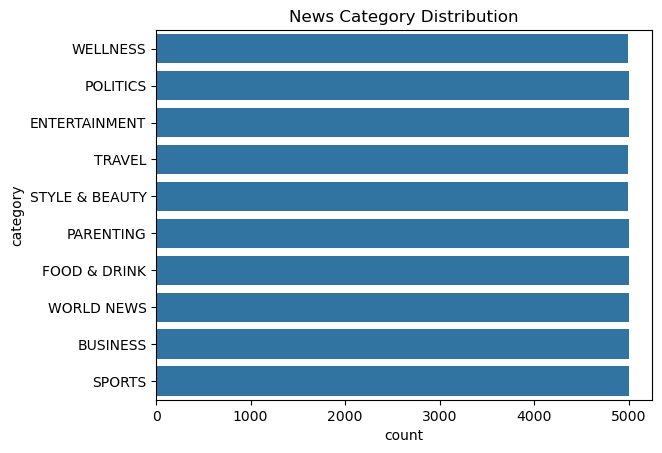

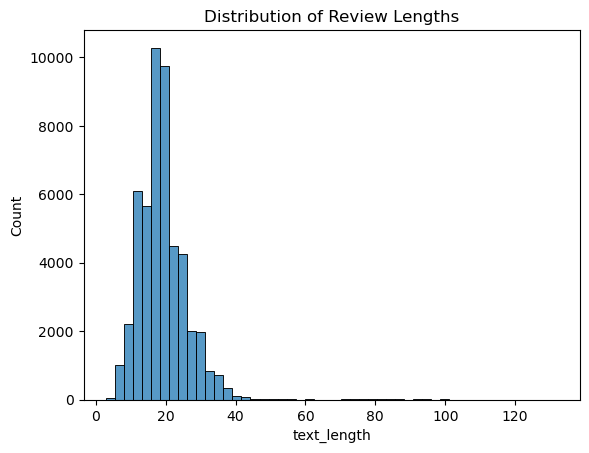

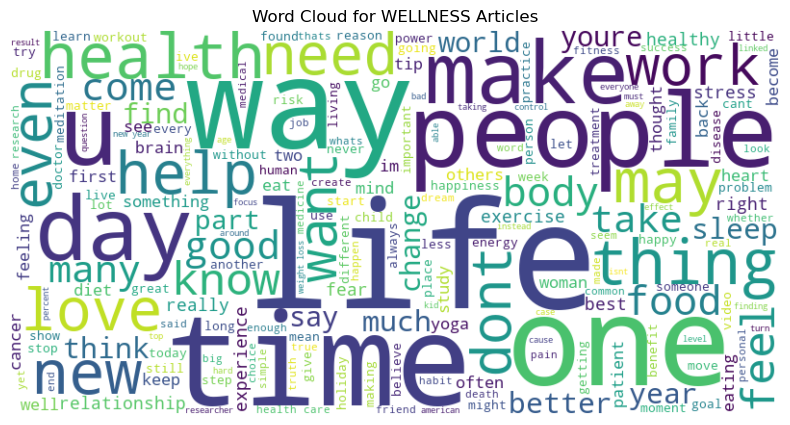

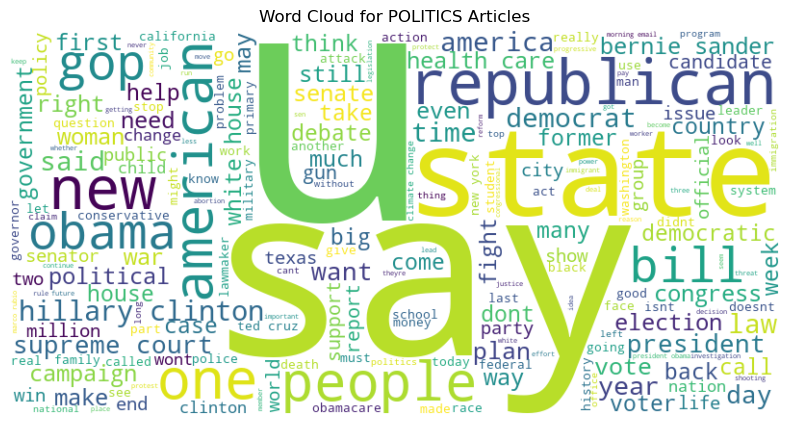

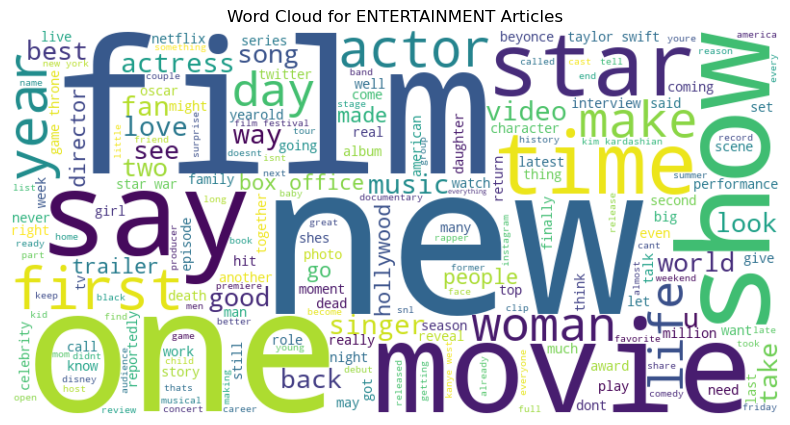

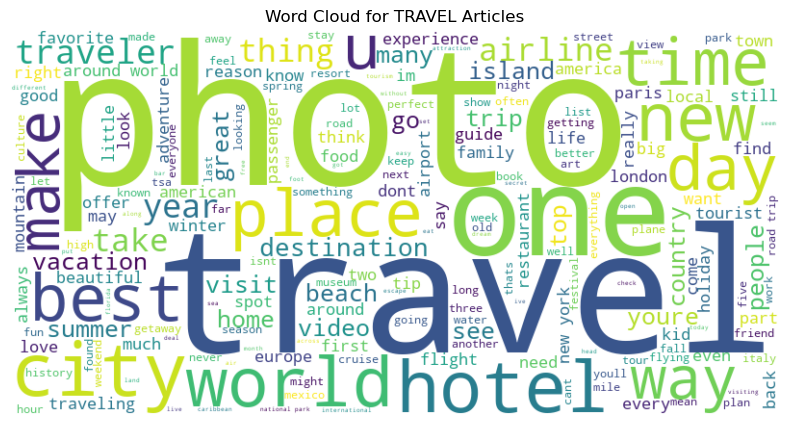

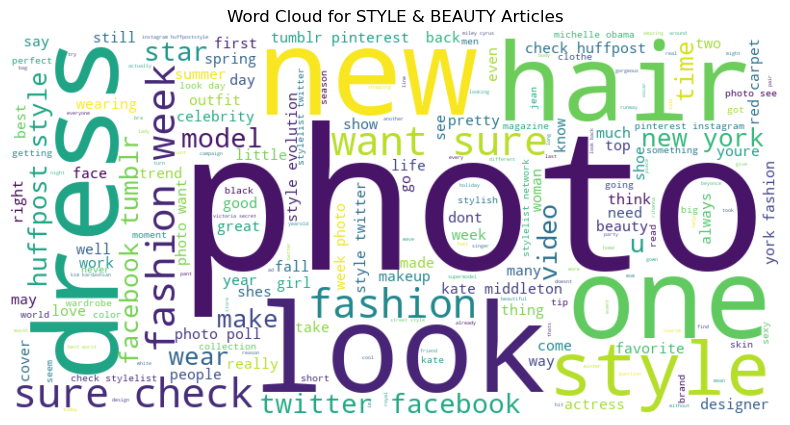

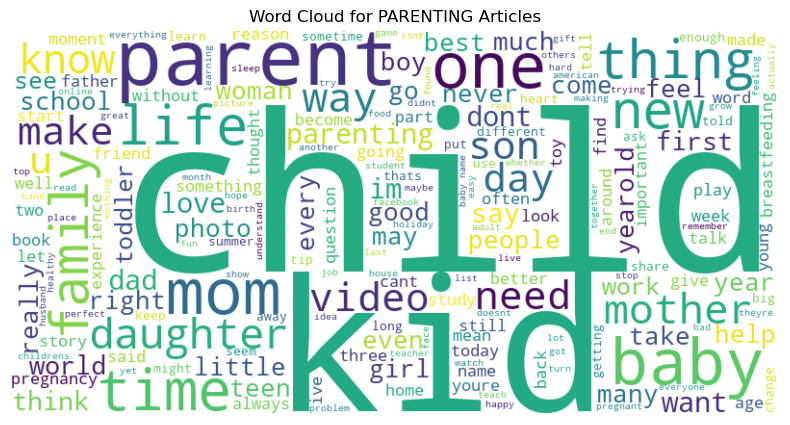

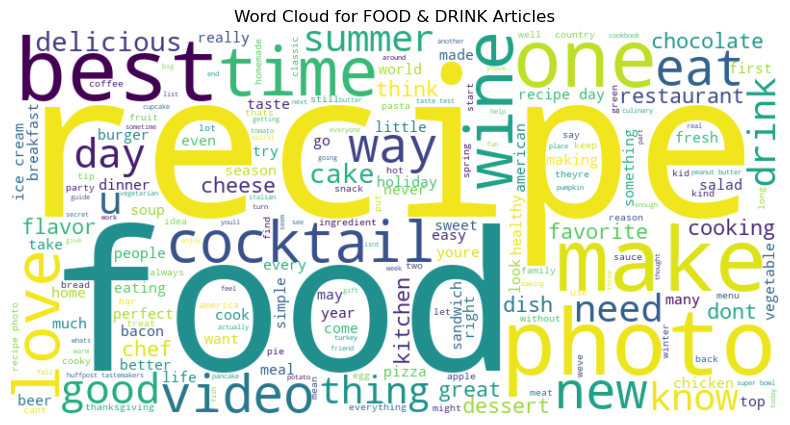

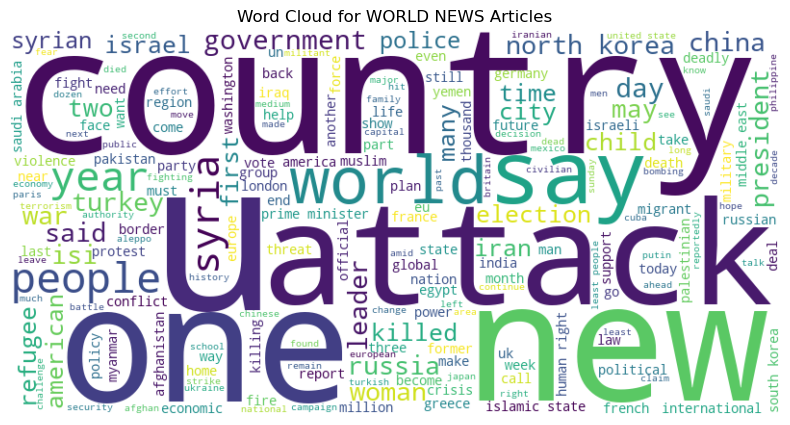

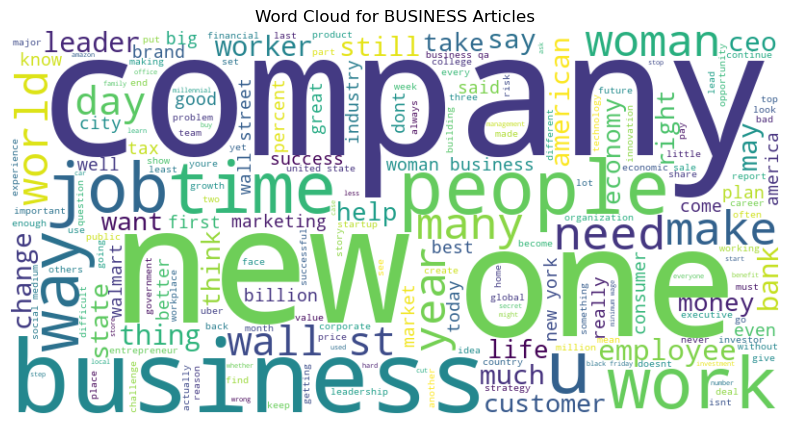

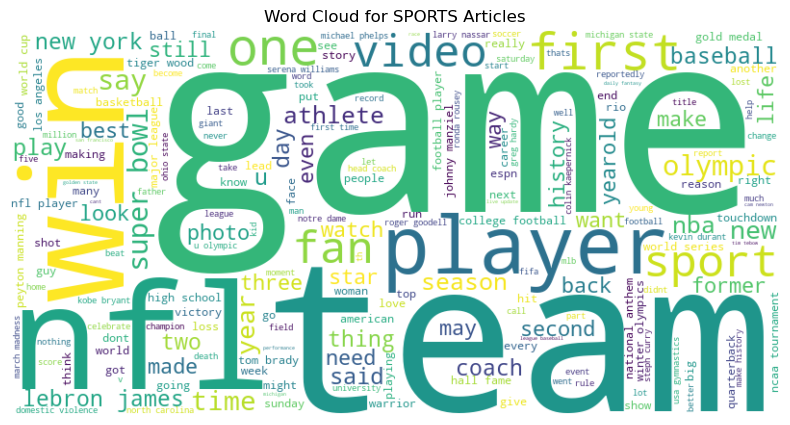

In [45]:
#  4. EDA
sns.countplot(y='category', data=df)
plt.title('News Category Distribution')
plt.show()
df['text_length'] = df['cleaned_content'].apply(lambda x: len(x.split()))
sns.histplot(df['text_length'], bins=50)
plt.title('Distribution of Review Lengths')
plt.show()

# Word Clouds
categories = df['category'].unique()
for cat in categories:
    text = ' '.join(df[df['category'] == cat]['cleaned_content'])
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {cat} Articles")
    plt.show()

In [52]:
# 5. Feature Extraction (TF-IDF)
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_content'])

# Label Encoding for XGBoost
y_raw = df['category']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_raw)

# Word2Vec Feature Extraction
tokenized_corpus = [text.split() for text in df['cleaned_content']]
w2v_model = Word2Vec(sentences=tokenized_corpus, vector_size=100, window=5, min_count=1, workers=4)
X_w2v = np.array([np.mean([w2v_model.wv[word] for word in words if word in w2v_model.wv] or [np.zeros(100)], axis=0) for words in tokenized_corpus])


In [53]:
#  6. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_raw, test_size=0.2, stratify=y_raw, random_state=42)
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(X_tfidf, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)
X_train_w2v, X_test_w2v, _, _ = train_test_split(X_w2v, y_raw, test_size=0.2, stratify=y_raw, random_state=42)


Logistic Regression Classification Report:
                precision    recall  f1-score   support

      BUSINESS       0.75      0.77      0.76      1000
 ENTERTAINMENT       0.77      0.78      0.77      1000
  FOOD & DRINK       0.85      0.86      0.86      1000
     PARENTING       0.76      0.76      0.76      1000
      POLITICS       0.77      0.73      0.75      1000
        SPORTS       0.88      0.89      0.88      1000
STYLE & BEAUTY       0.88      0.82      0.85      1000
        TRAVEL       0.79      0.79      0.79       999
      WELLNESS       0.73      0.78      0.75      1000
    WORLD NEWS       0.82      0.79      0.80      1000

      accuracy                           0.80      9999
     macro avg       0.80      0.80      0.80      9999
  weighted avg       0.80      0.80      0.80      9999

Accuracy: 0.7978797879787979
F1 Score: 0.7980252856349092


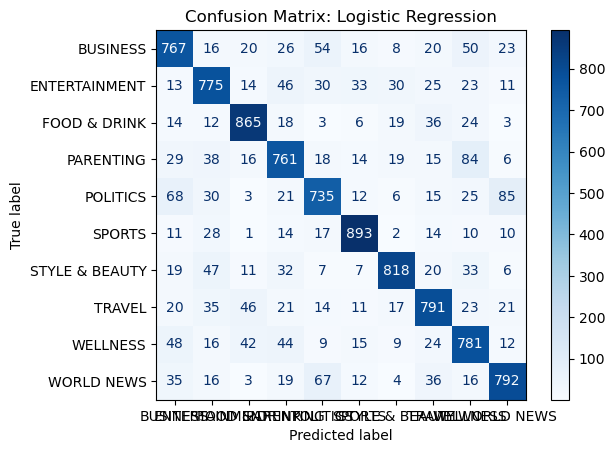

In [55]:
# Logistic Regression using TF-IDF features
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Model Training
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced')
lr_model.fit(X_train, y_train)

# Prediction
y_pred_lr = lr_model.predict(X_test)

# Evaluation
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

# Accuracy & F1 Score
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("F1 Score:", f1_score(y_test, y_pred_lr, average='weighted'))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lr, labels=np.unique(y_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix: Logistic Regression')
plt.show()

Tuned Logistic Regression Classification Report:
                precision    recall  f1-score   support

      BUSINESS       0.76      0.78      0.77      1000
 ENTERTAINMENT       0.77      0.77      0.77      1000
  FOOD & DRINK       0.85      0.86      0.86      1000
     PARENTING       0.76      0.77      0.77      1000
      POLITICS       0.77      0.74      0.76      1000
        SPORTS       0.89      0.90      0.90      1000
STYLE & BEAUTY       0.88      0.82      0.85      1000
        TRAVEL       0.79      0.79      0.79       999
      WELLNESS       0.74      0.78      0.76      1000
    WORLD NEWS       0.81      0.79      0.80      1000

      accuracy                           0.80      9999
     macro avg       0.80      0.80      0.80      9999
  weighted avg       0.80      0.80      0.80      9999

Best C value: 1.6601864044243653
Accuracy: 0.8012801280128012
F1 Score: 0.8013595250040229


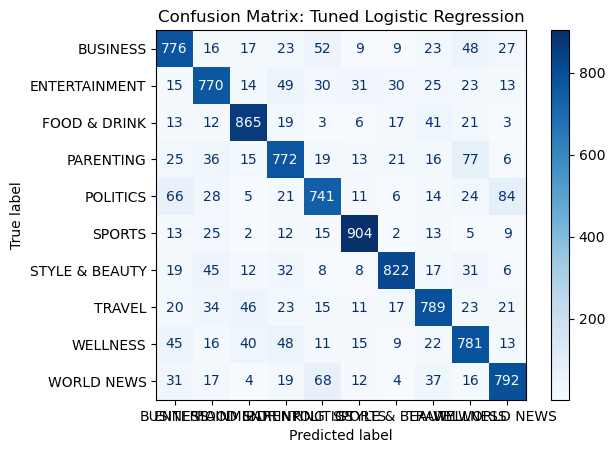

In [80]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.linear_model import LogisticRegression

# Define parameter space
param_dist_lr = {'C': uniform(0.1, 10)}

# Setup RandomizedSearchCV
search_lr = RandomizedSearchCV(
    LogisticRegression(max_iter=1000, class_weight='balanced'),
    param_distributions=param_dist_lr,
    n_iter=10,              # You can increase this if needed
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

# Perform Search
search_lr.fit(X_train, y_train)

# Best Model
best_lr_model = search_lr.best_estimator_

# Predictions
y_pred_lr_tuned = best_lr_model.predict(X_test)

# Evaluation
print("Tuned Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr_tuned))

# Accuracy & F1 Score
print("Best C value:", search_lr.best_params_['C'])
print("Accuracy:", accuracy_score(y_test, y_pred_lr_tuned))
print("F1 Score:", f1_score(y_test, y_pred_lr_tuned, average='weighted'))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lr_tuned, labels=np.unique(y_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix: Tuned Logistic Regression')
plt.show()

Naive Bayes Classification Report:
                precision    recall  f1-score   support

      BUSINESS       0.75      0.71      0.73      1000
 ENTERTAINMENT       0.80      0.77      0.78      1000
  FOOD & DRINK       0.82      0.86      0.84      1000
     PARENTING       0.69      0.77      0.73      1000
      POLITICS       0.76      0.72      0.74      1000
        SPORTS       0.89      0.84      0.87      1000
STYLE & BEAUTY       0.86      0.80      0.83      1000
        TRAVEL       0.76      0.80      0.78       999
      WELLNESS       0.72      0.76      0.74      1000
    WORLD NEWS       0.80      0.79      0.79      1000

      accuracy                           0.78      9999
     macro avg       0.78      0.78      0.78      9999
  weighted avg       0.78      0.78      0.78      9999

Accuracy: 0.7820782078207821
F1 Score: 0.7825564556575093


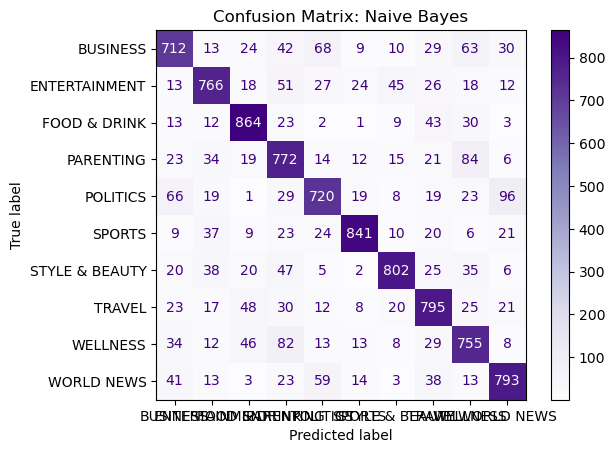

In [56]:
# Naive Bayes using TF-IDF features
from sklearn.naive_bayes import MultinomialNB

# Model Training
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Prediction
y_pred_nb = nb_model.predict(X_test)

# Evaluation
print("Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))

# Accuracy & F1 Score
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("F1 Score:", f1_score(y_test, y_pred_nb, average='weighted'))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_nb, labels=np.unique(y_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='Purples')
plt.title('Confusion Matrix: Naive Bayes')

plt.show()

Tuned Random Forest Classification Report:
                precision    recall  f1-score   support

      BUSINESS       0.80      0.82      0.81      1000
 ENTERTAINMENT       0.70      0.66      0.68      1000
  FOOD & DRINK       0.75      0.83      0.79      1000
     PARENTING       0.72      0.76      0.74      1000
      POLITICS       0.74      0.63      0.68      1000
        SPORTS       0.84      0.91      0.87      1000
STYLE & BEAUTY       0.78      0.78      0.78      1000
        TRAVEL       0.73      0.64      0.68       999
      WELLNESS       0.64      0.70      0.67      1000
    WORLD NEWS       0.72      0.69      0.70      1000

      accuracy                           0.74      9999
     macro avg       0.74      0.74      0.74      9999
  weighted avg       0.74      0.74      0.74      9999

Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': None, 'bootstrap': True}
Accuracy: 0.7416741674167416
F1 Score: 0.7400472282596312


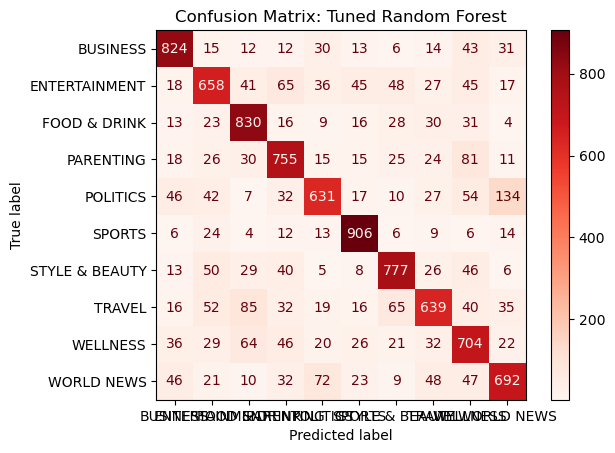

In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define parameter space
param_dist_rf = {
    'n_estimators': [50,100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'bootstrap': [True]
}

# Setup RandomizedSearchCV
search_rf = RandomizedSearchCV(
    RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42),
    param_distributions=param_dist_rf,
    n_iter=5,                # You can increase n_iter for deeper search
    cv=2,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

# Perform Search
search_rf.fit(X_train, y_train)

# Best Model
best_rf_model = search_rf.best_estimator_

# Predictions
y_pred_rf = best_rf_model.predict(X_test)

# Evaluation
print("Tuned Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

print("Best Parameters:", search_rf.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf, average='weighted'))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf, labels=np.unique(y_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='Reds')
plt.title('Confusion Matrix: Tuned Random Forest')
plt.show()

SVM Classification Report:
                precision    recall  f1-score   support

      BUSINESS       0.76      0.80      0.78      1000
 ENTERTAINMENT       0.79      0.76      0.77      1000
  FOOD & DRINK       0.83      0.86      0.84      1000
     PARENTING       0.75      0.77      0.76      1000
      POLITICS       0.76      0.73      0.75      1000
        SPORTS       0.88      0.92      0.90      1000
STYLE & BEAUTY       0.86      0.83      0.85      1000
        TRAVEL       0.78      0.77      0.78       999
      WELLNESS       0.75      0.76      0.75      1000
    WORLD NEWS       0.81      0.78      0.79      1000

      accuracy                           0.80      9999
     macro avg       0.80      0.80      0.80      9999
  weighted avg       0.80      0.80      0.80      9999

Accuracy: 0.7960796079607961
F1 Score: 0.7958176336530203


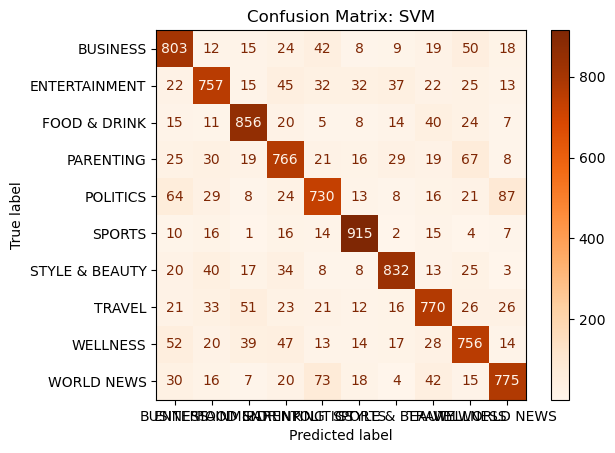

In [57]:
# SVM using TF-IDF features
from sklearn.svm import LinearSVC

# Model Training
svm_model = LinearSVC(class_weight='balanced', max_iter=1000)
svm_model.fit(X_train, y_train)

# Prediction
y_pred_svm = svm_model.predict(X_test)

# Evaluation
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

# Accuracy & F1 Score
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("F1 Score:", f1_score(y_test, y_pred_svm, average='weighted'))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_svm, labels=np.unique(y_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='Oranges')
plt.title('Confusion Matrix: SVM')
plt.show()


                 Model  Accuracy  F1-Score  CV-Accuracy
0  Logistic Regression  0.797880  0.798025     0.790599
2                  SVM  0.796080  0.795818     0.782423
1          Naive Bayes  0.782078  0.782556     0.777897
3        Random Forest  0.742374  0.740579     0.726466


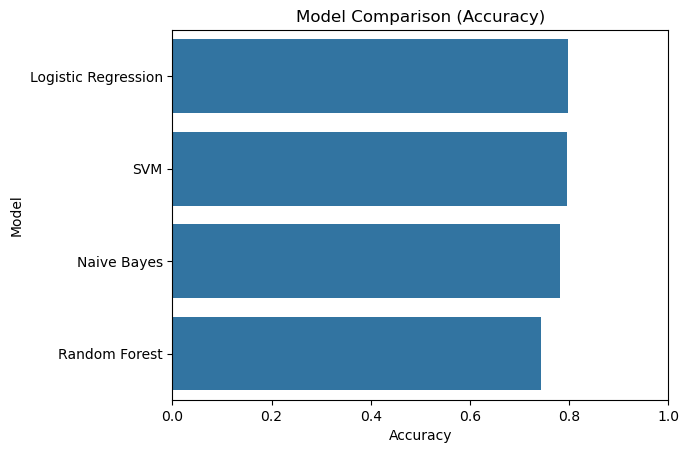

In [62]:
# 9. Results Summary
results_df = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)
print(results_df)
sns.barplot(x='Accuracy', y='Model', data=results_df)
plt.title('Model Comparison (Accuracy)')
plt.xlim(0, 1)
plt.show()

# Word2Vec

In [5]:
from gensim.models import Word2Vec
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

# 1: Tokenize Corpus
tokenized_corpus = [text.split() for text in df['cleaned_content']]

# 2: Train Word2Vec
w2v_model = Word2Vec(sentences=tokenized_corpus, vector_size=100, window=5, min_count=1, workers=4)

# 3: Average Vectors for Each Article
def get_avg_vector(words, model, vector_size=100):
    vectors = [model.wv[word] for word in words if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(vector_size)

X_w2v = np.array([get_avg_vector(words, w2v_model) for words in tokenized_corpus])

# 4: Train-Test Split
from sklearn.model_selection import train_test_split
X_train_w2v, X_test_w2v, y_train, y_test = train_test_split(X_w2v, df['category'], test_size=0.2, stratify=df['category'], random_state=42)

# 5: Train Classifiers

## Logistic Regression
lr_model_w2v = LogisticRegression(max_iter=1000)
lr_model_w2v.fit(X_train_w2v, y_train)
y_pred_lr_w2v = lr_model_w2v.predict(X_test_w2v)

print("\nWord2Vec + Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_lr_w2v))
print(classification_report(y_test, y_pred_lr_w2v))

## SVM
svm_model_w2v = LinearSVC(max_iter=1000)
svm_model_w2v.fit(X_train_w2v, y_train)
y_pred_svm_w2v = svm_model_w2v.predict(X_test_w2v)

print("\nWord2Vec + SVM")
print("Accuracy:", accuracy_score(y_test, y_pred_svm_w2v))
print(classification_report(y_test, y_pred_svm_w2v))



Word2Vec + Logistic Regression
Accuracy: 0.5335533553355336
                precision    recall  f1-score   support

      BUSINESS       0.43      0.40      0.41      1000
 ENTERTAINMENT       0.44      0.50      0.47      1000
  FOOD & DRINK       0.63      0.67      0.65      1000
     PARENTING       0.57      0.56      0.56      1000
      POLITICS       0.58      0.50      0.54      1000
        SPORTS       0.55      0.48      0.51      1000
STYLE & BEAUTY       0.65      0.60      0.62      1000
        TRAVEL       0.50      0.47      0.48       999
      WELLNESS       0.47      0.53      0.50      1000
    WORLD NEWS       0.54      0.64      0.58      1000

      accuracy                           0.53      9999
     macro avg       0.54      0.53      0.53      9999
  weighted avg       0.54      0.53      0.53      9999


Word2Vec + SVM
Accuracy: 0.575957595759576
                precision    recall  f1-score   support

      BUSINESS       0.50      0.44      0.47      

In [7]:
from gensim.models import Word2Vec
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# 1: Tokenize Corpus
tokenized_corpus = [text.split() for text in df['cleaned_content']]

# 2: Train Word2Vec
w2v_model = Word2Vec(sentences=tokenized_corpus, vector_size=100, window=5, min_count=1, workers=4)

# 3: Generate Average Vectors
def get_avg_vector(words, model, vector_size=100):
    vectors = [model.wv[word] for word in words if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(vector_size)

X_w2v = np.array([get_avg_vector(words, w2v_model) for words in tokenized_corpus])

# 4: Train-Test Split
from sklearn.model_selection import train_test_split

X_train_w2v, X_test_w2v, y_train, y_test = train_test_split(
    X_w2v, df['category'], test_size=0.2, stratify=df['category'], random_state=42
)

# 5: Label Encode Targets for XGBoost
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# 6: Models Training & Evaluation

models_w2v = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': LinearSVC(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, n_jobs=-1),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_jobs=-1)
}

results_w2v = []

for name, model in models_w2v.items():
    print(f"\nTraining {name} on Word2Vec embeddings...")

    if name == 'XGBoost':
        model.fit(X_train_w2v, y_train_encoded)
        y_pred = model.predict(X_test_w2v)
        y_pred_labels = label_encoder.inverse_transform(y_pred)
    else:
        model.fit(X_train_w2v, y_train)
        y_pred_labels = model.predict(X_test_w2v)

    acc = accuracy_score(y_test, y_pred_labels)
    print(f"{name} Accuracy (Word2Vec): {acc:.4f}")
    print(classification_report(y_test, y_pred_labels))

    results_w2v.append({'Model': f"{name} (Word2Vec)", 'Accuracy': acc})

# 7: Results Summary
import pandas as pd
df_results_w2v = pd.DataFrame(results_w2v).sort_values(by='Accuracy', ascending=False)
print(df_results_w2v)



Training Logistic Regression on Word2Vec embeddings...
Logistic Regression Accuracy (Word2Vec): 0.5375
                precision    recall  f1-score   support

      BUSINESS       0.42      0.41      0.41      1000
 ENTERTAINMENT       0.44      0.51      0.47      1000
  FOOD & DRINK       0.63      0.68      0.65      1000
     PARENTING       0.57      0.57      0.57      1000
      POLITICS       0.58      0.50      0.54      1000
        SPORTS       0.57      0.46      0.51      1000
STYLE & BEAUTY       0.66      0.60      0.63      1000
        TRAVEL       0.49      0.49      0.49       999
      WELLNESS       0.48      0.53      0.51      1000
    WORLD NEWS       0.54      0.64      0.59      1000

      accuracy                           0.54      9999
     macro avg       0.54      0.54      0.54      9999
  weighted avg       0.54      0.54      0.54      9999


Training SVM on Word2Vec embeddings...
SVM Accuracy (Word2Vec): 0.5760
                precision    recall  

C:\Users\danis\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:32:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy (Word2Vec): 0.5730
                precision    recall  f1-score   support

      BUSINESS       0.63      0.66      0.64      1000
 ENTERTAINMENT       0.44      0.45      0.44      1000
  FOOD & DRINK       0.64      0.66      0.65      1000
     PARENTING       0.55      0.54      0.54      1000
      POLITICS       0.57      0.52      0.54      1000
        SPORTS       0.74      0.76      0.75      1000
STYLE & BEAUTY       0.65      0.59      0.62      1000
        TRAVEL       0.47      0.47      0.47       999
      WELLNESS       0.47      0.48      0.47      1000
    WORLD NEWS       0.58      0.61      0.60      1000

      accuracy                           0.57      9999
     macro avg       0.57      0.57      0.57      9999
  weighted avg       0.57      0.57      0.57      9999

                            Model  Accuracy
1                  SVM (Word2Vec)  0.575958
3              XGBoost (Word2Vec)  0.572957
2        Random Forest (Word2Vec)  0.553655
0

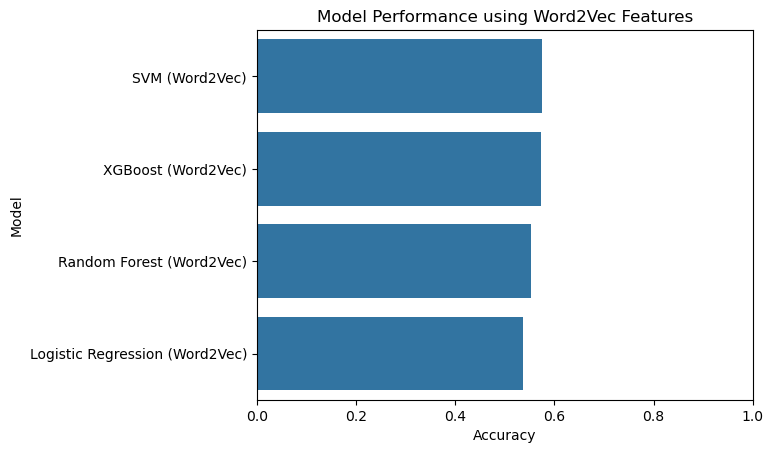

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x='Accuracy', y='Model', data=df_results_w2v)
plt.title('Model Performance using Word2Vec Features')
plt.xlim(0, 1)
plt.show()

# Making Prediction Model

In [79]:

def predict_article_category(text, vectorizer=tfidf_vectorizer, model=models['Logistic Regression']):
    cleaned = preprocess_text(text)
    vector = vectorizer.transform([cleaned])
    prediction = model.predict(vector)[0]
    return prediction

# Example:
example_article = input("\nEnter your news article content:\n")
predicted_category = predict_article_category(example_article)
print("\nPredicted Category:", predicted_category)


Enter your news article content:
 It is delicious and tastes well when it is hot.



Predicted Category: FOOD & DRINK



## Models developed:

1. Logistic Regression (with and without hyperparameter tuning)
2. Naive Bayes
3. Support Vector Machine (SVM)
4. Random Forest Classifier (with hyperparameter tuning)

## Hyperparameter Tuning:

1. Logistic Regression (C value)
2. Random Forest (n_estimators, max_depth, bootstrap)


## Best Performing Models:

1. Tuned Logistic Regression (Accuracy: 80.1%, F1-Score: 0.80)
2. SVM performed comparably.
3. Random Forest showed lower performance despite tuning.

#### New Article Prediction Example:

###### Input: “It is delicious and tastes well when it is hot.”
###### Predicted Category: FOOD & DRINK

TF-IDF weights and Word Clouds highlighted important keywords specific to each category.
Logistic Regression and SVM emerged as best-suited for this classification task.
Business, Food & Drink, and Sports articles showed consistently higher accuracy and F1 scores compared to smaller categories like Parenting and Wellness.

# Conclusion
A robust multi-class classification system was developed, achieving ~80% accuracy on unseen news articles.TF-IDF combined with Logistic Regression or SVM offered the most reliable results.

The model successfully supports real-time article classification based on user input.